In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

random.seed(42)

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from torchmetrics import Accuracy

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

from PIL import Image

from pathlib import Path

# Open images

In [2]:
from os import listdir
from os.path import isfile, join

image_paths = [
                ('../data/interim/train/seal', '../data/interim/train/no_seal'),
                ('../data/interim/test/seal', '../data/interim/test/no_seal'), 
                ('../data/interim/eval/seal', '../data/interim/eval/no_seal')
              ]

data = []
for img_path in image_paths:
    data.append([f for f in listdir(img_path[0]) if isfile(join(img_path[0], f))] + \
                    [f for f in listdir(img_path[1]) if isfile(join(img_path[1], f))])

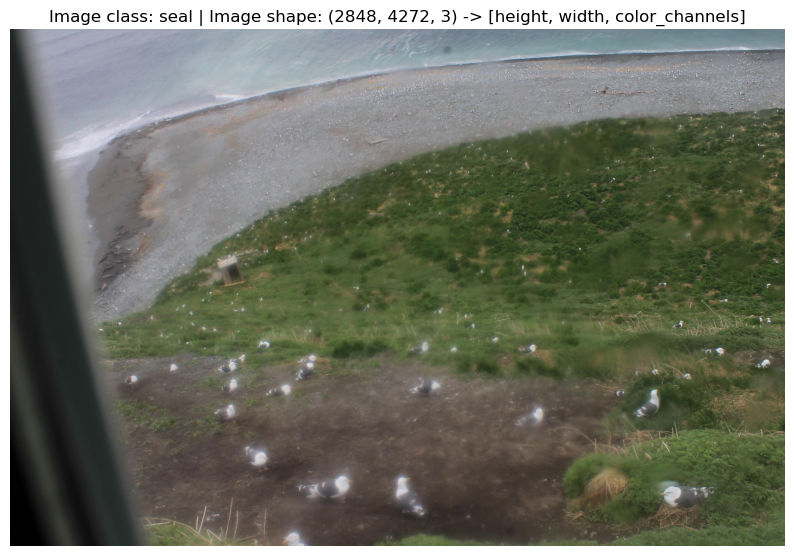

In [3]:
image_path_list = list(Path(image_paths[0][0]).glob("*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [23]:
class SealDataset(Dataset):
    def __init__(self, images_direction, transform = None):
        
        self.paths = list(Path(images_direction).glob("*/*.jpg"))
        self.transform = transform
        
        self.classes, self.class_to_idx = (['no_seal', 'seal'], {'no_seal': 0, 'seal': 1})
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name  = self.paths[idx].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [24]:
train_data = SealDataset('../data/interim/train', transform = train_transforms)
test_data = SealDataset('../data/interim/test', transform = test_transforms)
eval_data = SealDataset('../data/interim/eval', transform = test_transforms)

In [25]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

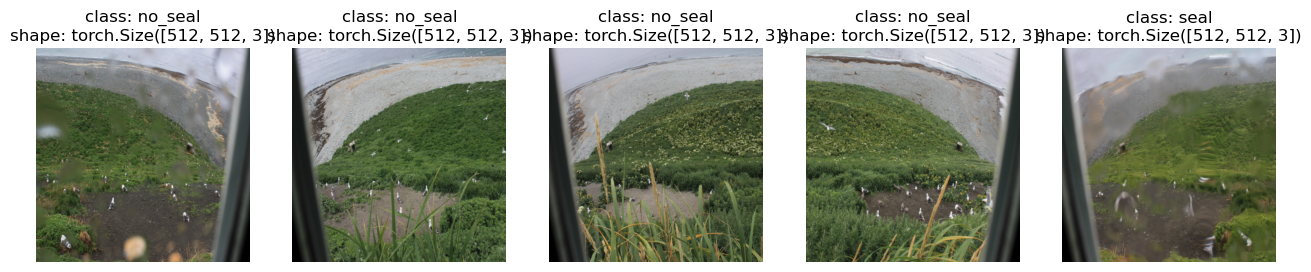

In [26]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=['no_seal', 'seal'])

# Classification model

In [31]:
class SealDatasetPL(pl.LightningDataModule):
    def __init__(self, batch_size: int = 64, num_workers: int = 8, transform = None):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
   
    def prepare_data(self):
        pass
    
    def setup(self, stage: str = None):
        if stage == 'fit' or stage is None:
            self.train = SealDataset(
                                    '../data/interim/train', 
                                    transform = self.transform
                                    )
            self.validate = SealDataset(
                                    '../data/interim/eval',
                                    transform = self.transform
                                    )
        
        if stage == 'test' or stage is None:
            self.test = SealDataset(
                                    '../data/interim/test',
                                    transform = self.transform
                                    )
    
        def train_dataloader(self):
            return DataLoader(self.train, batch_size=self.batch_size, num_workers=self.num_workers)

        def val_dataloader(self):
            return DataLoader(self.validate, batch_size=self.batch_size, num_workers=self.num_workers)

        def test_dataloader(self):
            return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)

In [36]:

class SealClassificationModel(pl.LightningModule):
    def __init__(self, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.neural_net = models.resnet50(pretrained= True)
        self.neural_net.fc = torch.nn.Linear(2048,2)
        
    
    def forward(self, x):
        return self.neural_net(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma=0.5, last_epoch=-1, verbose=False)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "val_loss",
            },
        }
    
    def training_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        #y = y.unsqueeze(-1)
        loss = self.loss_func(y_pred,y)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        #y = y.unsqueeze(-1)
        loss = self.loss_func(y_pred,y)
        self.log("val_loss" ,loss )
        return loss
    def test_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        #y = y.unsqueeze(-1)
        loss = self.loss_func(y_pred,y)
        self.log("test_loss : " , loss)
        return loss

In [39]:
torch.cuda.is_available()

False

In [38]:
from pytorch_lightning import Trainer
model = SealClassificationModel()
data = SealDatasetPL()
trainer = Trainer(max_epochs=1)
trainer.fit(model, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Missing logger folder: C:\Users\User\Desktop\projects\true ml project\sea

MisconfigurationException: `train_dataloader` must be implemented to be used with the Lightning Trainer